# Exercise 8: Put all the concepts in Exercise 7 together

Skills:
* Apply all the concepts covered in Exercise 7 for a research question. Know when to use what concept.

References: 
* Exercise 7


### To Do

Narrow down the list of rail routes in CA to 3 groups. Use the SHN network to determine how much of the rail route runs near the SHN. We care only about rail routes that run entirely in CA (use stops to figure this out).

**Near** the interstate, US highway, or state highway is defined by being within a quarter mile. For this exercise, the distinction between interstate, US highway, and state highway is not important; treat any road that shows up in the dataset as "the SHN".

There are theoretically 3 groupings: 
* rail routes that are never within 0.25 miles of the SHN (>0.25
* rail routes with > 0 but less than half of its length near the SHN (0<x<0.5)
* rail routes with at least half of its length near the SHN(

Provide a table and a chart showing how many rail routes fall into each of the 3 groups by district.

Use a Markdown cell at the end to connect which geospatial concept was applied to which step of the process. The concepts that should be used are `projecting CRS`, `buffering`, `dissolve`, `clipping`, `spatial join`, `overlay`. 

---
---
## Notes
* all imported dfs are gdf 
* all with CRS 4326 (decimal degrees)
* all with active geometry col set to `geometry`
* all gdf filtered down to rail groups 0, 1 and 2
* geometry type for each gdf
    1. districts - polygon
    2. ca_highways - multi line string 
    3. routes - line string
    4. rail_routes - line string
    5. stops - point
    6. rail_stops - point
* check the plots of all the gdfs
* gdf not in CA
    1. routes (nationwide)
    2. rail routes (nationwide)
    3. stops 
    4. rail stops 
---
## Cleaning

COMPLETE project all gdf to `EPSG:2229` to get everything in feet and clip all gdf to California only
COMPLETE 1. dissolve districts map to be CA only.
    * `ca` - California polygon 
COMPLETE 2. update `ca_highways` map to new CRS
COMPLETE 3. clip the other gdf to CA map. 

    * `ca_routes` - transit routes in CA
    * `ca_rail` - rail routes in CA for 0,1,2
    * `ca_stops` - transit stops in CA
    * `ca_rail_stops` - rail stops in CA for 0,1,2
COMPLETE 4. dissolve these ca maps to see what you get
    * `ca_routes_d`
    * `ca_rail_d`
    * `ca_stops_d`  
    * `ca_rail_stops_d`

5. check all new gdf against `gdf_check` function to ensure everything looks good
   
---
---

In [1]:
import geopandas as gpd
import intake
import pandas as pd

catalog = intake.open_catalog(
    "../_shared_utils/shared_utils/shared_data_catalog.yml")

In [2]:
# Import data
districts = catalog.caltrans_districts.read()
ca_highways = catalog.state_highway_network.read()

rail_group = ['0', '1', '2']
routes = catalog.ca_transit_routes.read()
rail_routes = routes[routes.route_type.isin(rail_group)
                    ].reset_index(drop=True)

stops = catalog.ca_transit_stops.read()
rail_stops = stops[stops.route_type.isin(rail_group)
                  ].reset_index(drop=True)

---

## Geodataframe checks

---

In [3]:
#function that checks multiple aspects of a gdf

def gdf_check(gdf):(
    print(f'Dataframe type is = {type(gdf)}'),
    print(f'GDF shape is = {gdf.shape}'),
    print(f'Active geometry col name is = {gdf.geometry.name}'),
    display(gdf.head()),
    display(gdf.plot()),
    display(gdf.crs)
    )

In [ ]:
#gdf of caltrans districts
#1 row for each districts, each district is a polygon

    #gdf_check(districts)

In [ ]:
#gdf of CA highways
#each row is a segment of a route, 

    #gdf_check(ca_highways)

In [ ]:
    #rail_group

In [ ]:
#gdf of all transit routes, nation wide?

    #gdf_check(routes)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (209, 10)
Active geometry col name is = geometry


,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry
0,recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,245,6,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-73.74115 42.64103, -73.74159 42.6..."
1,recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,248,6,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-73.99446 40.75033, -74.00083 40.7..."
2,recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,279,2,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-73.99446 40.75033, -74.00083 40.7..."
3,recKsb5FnJy70up78,Amtrak,36921,2,Empire Service,280,2,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-79.03186 43.11355, -79.03157 43.1..."
4,recKsb5FnJy70up78,Amtrak,36922,2,Capitol Limited,238,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (-77.00642 38.89699, -76.99970 38.9..."


<AxesSubplot:>

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

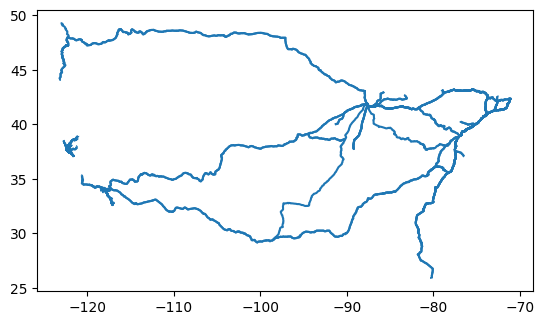

In [47]:
#gdf of all rail routes, for the sub rail-group

gdf_check(rail_routes)

In [ ]:
#gdf of all transit stops

    #gdf_check(stops)

In [ ]:
#gdf of all rail stops

    #gdf_check(rail_stops)

---

## Cleaning

---

In [4]:
#setting crs and dissolving district map to one polygon
#only kept the following columns, other columns were left out.

ca = districts[['geometry', 'Shape__Area', 'Shape__Length']].to_crs('EPSG:2229').dissolve()


In [5]:
#updating initial districts gdf to new CRS
districts = districts.to_crs('EPSG:2229')


In [6]:
#update CRS for ca_highways
ca_highways = ca_highways.to_crs('EPSG:2229')


Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (242, 6)
Active geometry col name is = geometry


,Route,geometry,County,District,RouteType,Direction
0,1,"MULTILINESTRING ((6518147.781 1746024.206, 651...",LA,7,State,NB
1,2,"MULTILINESTRING ((6490992.937 1865622.285, 649...",LA,7,State,EB
2,3,"MULTILINESTRING ((5275615.149 4654447.197, 527...",SIS,2,State,NB
3,4,"MULTILINESTRING ((5983573.255 3460229.889, 598...",ALP,10,State,EB
4,5,"MULTILINESTRING ((5405204.172 3674443.942, 540...",COL,3,Interstate,NB


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

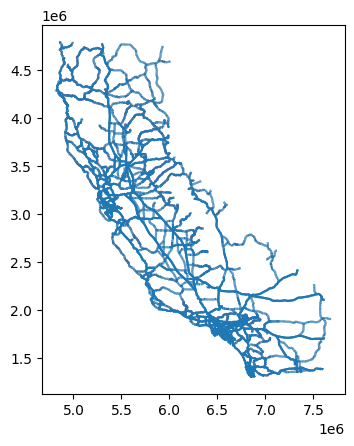

In [48]:
#CA highway gdf dissolved to get consolidate routes and reset index
ca_highways2 = ca_highways.dissolve(by='Route').reset_index()
gdf_check(ca_highways2)

In [9]:
#test to combine clipping and CRS
#TEST WORKS! apply same to other gdfs

#update CRS to feet and clip transit routes to CA. outcome is tranits routes in CA only
#ca_routes = routes.to_crs('EPSG:2229').clip(ca)

In [10]:
#clipped rail routes to CA only
ca_rail = rail_routes.to_crs('EPSG:2229').clip(ca)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (43, 11)
Active geometry col name is = geom_buff


,route_id,geom_buff,org_id,agency,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry
0,36930,"POLYGON ((7208303.849 1636404.080, 7208188.951...",recKsb5FnJy70up78,Amtrak,2,Sunset Limited,269,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((7602807.693 1377257.623, 760..."
1,398,"POLYGON ((6754757.919 1526704.211, 6755220.959...",recRBcrX4ZvTyvSnm,North County Transit District,2,COASTER,3980014,15,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,"LINESTRING (6752456.581 1527639.188, 6752915.6..."
2,399,"POLYGON ((6754673.376 1526896.526, 6754762.820...",recRBcrX4ZvTyvSnm,North County Transit District,0,SPRINTER,3990004,34,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,"LINESTRING (6751909.888 1528495.892, 6753315.8..."
3,507,"POLYGON ((5558965.342 3505259.128, 5558958.407...",rec43oyrfhtPDdRHj,City of Rancho Cordova,0,Downtown - Folsom,46380,26,aHR0cHM6Ly9pcG9ydGFsLnNhY3J0LmNvbS9HVEZTL1NSVE...,https://iportal.sacrt.com/GTFS/SRTD/google_tra...,"MULTILINESTRING ((5626117.107 3515594.727, 562..."
4,51,"POLYGON ((6489445.068 1844204.366, 6490021.030...",recKsb5FnJy70up78,Amtrak,2,Southwest Chief,118,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (6489947.165 1842910.544, 6490209.2..."


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

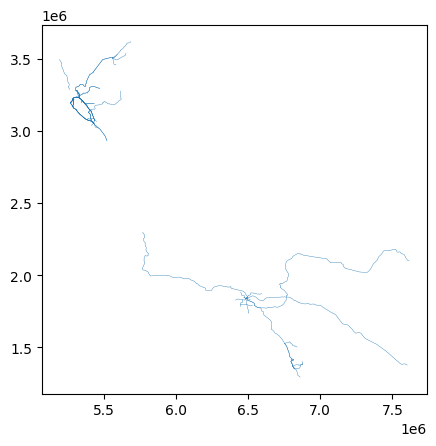

In [49]:
#ca_rail routes with new active geometry column buffered to .25mi
ca_rail2 = ca_rail.assign(geom_buff = ca_rail.geometry.buffer(1320)).set_geometry('geom_buff').dissolve(by='route_id').reset_index()
gdf_check(ca_rail2)


In [ ]:
#clipped transit stops to CA only
#ca_stops = stops.to_crs('EPSG:2229').clip(ca)

In [ ]:
#clipped rail stops to CA only
#ca_rail_stops = rail_stops.to_crs('EPSG:2229').clip(ca)

---
---
# Questions to answer
### (list of) rail routes that are never within 0.25 miles of the SHN
    * need:
        1. rail route map
        2. highway map
        need to buffer highway map to 1320ft.
        use overlay `systemic difference` to get get rai routes THAT DO NOT touch the buffered highway?!
        

### (list of) rail routes with > 0 but less than half of its length near the SHN
    1. buffered rail route with length col to < half_len
    2. 
    

### (list of) rail routes with at least half of its length near the SHN
    1. buffered rail route with length col to >= half_len

---
---

In [13]:
ca_highways2.head()

,Route,geometry,County,District,RouteType,Direction
0,1,"MULTILINESTRING ((6518147.781 1746024.206, 651...",LA,7,State,NB
1,2,"MULTILINESTRING ((6490992.937 1865622.285, 649...",LA,7,State,EB
2,3,"MULTILINESTRING ((5275615.149 4654447.197, 527...",SIS,2,State,NB
3,4,"MULTILINESTRING ((5983573.255 3460229.889, 598...",ALP,10,State,EB
4,5,"MULTILINESTRING ((5405204.172 3674443.942, 540...",COL,3,Interstate,NB


In [16]:
#renameing columns to make it easier to see in joins/overlays)
ca_highways2 = ca_highways2.rename(columns={'Route':'hw_Route', 'geometry': 'hw_geometry'}).set_geometry('hw_geometry')

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (242, 6)
Active geometry col name is = hw_geometry


,hw_Route,hw_geometry,County,District,RouteType,Direction
0,1,"MULTILINESTRING ((6518147.781 1746024.206, 651...",LA,7,State,NB
1,2,"MULTILINESTRING ((6490992.937 1865622.285, 649...",LA,7,State,EB
2,3,"MULTILINESTRING ((5275615.149 4654447.197, 527...",SIS,2,State,NB
3,4,"MULTILINESTRING ((5983573.255 3460229.889, 598...",ALP,10,State,EB
4,5,"MULTILINESTRING ((5405204.172 3674443.942, 540...",COL,3,Interstate,NB


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

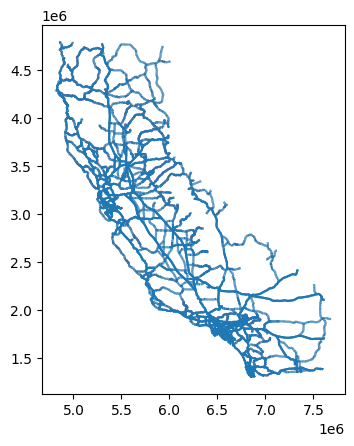

In [17]:
gdf_check(ca_highways2)

In [ ]:
#close look at the highways2 gdf
#ca_highways2.explore()

In [19]:
#added length col based on initial geometry col (multiline sting)
ca_rails2 = ca_rail2.assign(rail_len = ca_rail2.geometry.length)
ca_rails2 = ca_rails2.assign(half_rail_len = (ca_rail2.geometry.length/2))


In [ ]:
#can see the bufered part of ca_rails2 (1320ft)

#ca_rails2.explore()

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (43, 13)
Active geometry col name is = geom_buff


,route_id,geom_buff,org_id,agency,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry,rail_len,half_rail_len
0,36930,"POLYGON ((7208303.849 1636404.080, 7208188.951...",recKsb5FnJy70up78,Amtrak,2,Sunset Limited,269,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((7602807.693 1377257.623, 760...",2.634938e+06,1.317469e+06
1,398,"POLYGON ((6754757.919 1526704.211, 6755220.959...",recRBcrX4ZvTyvSnm,North County Transit District,2,COASTER,3980014,15,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,"LINESTRING (6752456.581 1527639.188, 6752915.6...",4.387197e+05,2.193598e+05
2,399,"POLYGON ((6754673.376 1526896.526, 6754762.820...",recRBcrX4ZvTyvSnm,North County Transit District,0,SPRINTER,3990004,34,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,"LINESTRING (6751909.888 1528495.892, 6753315.8...",2.363734e+05,1.181867e+05
3,507,"POLYGON ((5558965.342 3505259.128, 5558958.407...",rec43oyrfhtPDdRHj,City of Rancho Cordova,0,Downtown - Folsom,46380,26,aHR0cHM6Ly9pcG9ydGFsLnNhY3J0LmNvbS9HVEZTL1NSVE...,https://iportal.sacrt.com/GTFS/SRTD/google_tra...,"MULTILINESTRING ((5626117.107 3515594.727, 562...",2.445130e+05,1.222565e+05
4,51,"POLYGON ((6489445.068 1844204.366, 6490021.030...",recKsb5FnJy70up78,Amtrak,2,Southwest Chief,118,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"LINESTRING (6489947.165 1842910.544, 6490209.2...",3.479392e+06,1.739696e+06


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

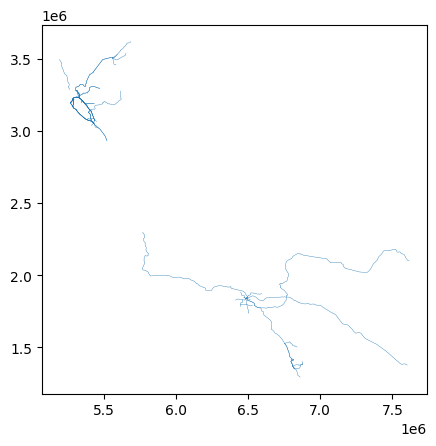

In [55]:
gdf_check(ca_rails2)

In [22]:
#test overlay with highway, then routes, intersection, keep_geom_type=false

overlay = gpd.overlay(ca_highways2, ca_rails2, how='intersection', keep_geom_type=False)

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (405, 17)
Active geometry col name is = geometry


,hw_Route,County,District,RouteType,Direction,route_id,org_id,agency,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry,rail_len,half_rail_len
0,1,LA,7,State,NB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6661196.635 1627312.440, 666...",3.688820e+06,1.844410e+06
1,2,LA,7,State,EB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6486246.110 1862321.877, 648...",3.688820e+06,1.844410e+06
2,5,COL,3,Interstate,NB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6480819.205 1874346.221, 648...",3.688820e+06,1.844410e+06
3,8,IMP,11,State,EB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6806534.199 1371713.094, 680...",3.688820e+06,1.844410e+06
4,10,LA,7,Interstate,EB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6489639.072 1842402.822, 648...",3.688820e+06,1.844410e+06


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

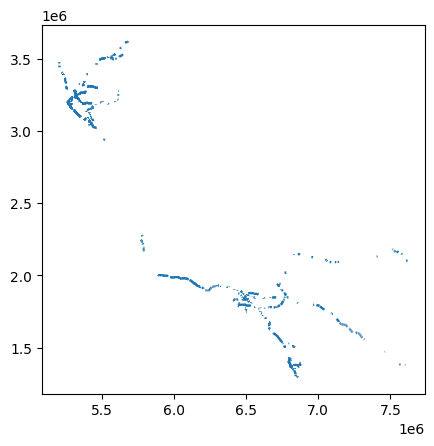

In [54]:
#test to see what happened
#can see the rails map is a lot more spoty than before 
#what do each of these rows tell me and why are there more rows now!?!?! 

#how='intersection', it returns only those geometries that are contained by both GeoDataFrames...meaning returns the parts of the rail routes that interesct the highway



gdf_check(overlay)

In [ ]:
#Used overlay to get a closer look at  the overlay gdf. saw polygons at the point of intersection between highway and trail routes. 

#overlay.explore()

In [26]:
#new col for geom lenth from overlay gdf

overlay_len = overlay.assign(geom_len = overlay.geometry.length)

overlay_len.head()

,hw_Route,County,District,RouteType,Direction,route_id,org_id,agency,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry,rail_len,half_rail_len,geom_len
0,1,LA,7,State,NB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6661196.635 1627312.440, 666...",3.688820e+06,1.844410e+06,120506.757419
1,2,LA,7,State,EB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6486246.110 1862321.877, 648...",3.688820e+06,1.844410e+06,5355.672289
2,5,COL,3,Interstate,NB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6480819.205 1874346.221, 648...",3.688820e+06,1.844410e+06,490155.508033
3,8,IMP,11,State,EB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6806534.199 1371713.094, 680...",3.688820e+06,1.844410e+06,5511.943490
4,10,LA,7,Interstate,EB,78,recKsb5FnJy70up78,Amtrak,2,Pacific Surfliner,101,5,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,"MULTILINESTRING ((6489639.072 1842402.822, 648...",3.688820e+06,1.844410e+06,14281.032076


In [51]:
overlay_len.route_id.value_counts()

78             34
CC             22
51             21
84             17
Green-N        15
Green-S        15
Orange-N       15
Orange-S       15
Blue-N         14
36930          14
Yellow-S       14
Yellow-N       14
Blue-S         14
Red-S          13
Red-N          13
ACE            11
L3             11
L4             11
801            11
L1             10
L5             10
B7              9
510             8
804             8
530             7
520             7
SMART           5
Orange Line     5
803             5
533             5
802             4
398             4
GreenS          3
805             3
507             3
BlueS           3
399             3
Beige-S         2
Beige-N         2
Blue Line       2
807             2
Red Line        1
Name: route_id, dtype: int64

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (42, 18)
Active geometry col name is = geometry


,route_id,route_name,geometry,hw_Route,County,District,RouteType,Direction,org_id,agency,route_type,shape_id,n_trips,base64_url,uri,rail_len,half_rail_len,geom_len
0,36930,Sunset Limited,"MULTILINESTRING ((6496618.037 1844254.138, 649...",5,COL,3,Interstate,NB,recKsb5FnJy70up78,Amtrak,2,269,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,2.634938e+06,1.317469e+06,5317.310534
1,398,COASTER,"MULTILINESTRING ((6798787.063 1426865.053, 679...",5,COL,3,Interstate,NB,recRBcrX4ZvTyvSnm,North County Transit District,2,3980014,15,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,4.387197e+05,2.193598e+05,158264.722030
2,399,SPRINTER,"MULTILINESTRING ((6757649.538 1527224.791, 675...",5,COL,3,Interstate,NB,recRBcrX4ZvTyvSnm,North County Transit District,0,3990004,34,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,2.363734e+05,1.181867e+05,5284.295672
3,507,Downtown - Folsom,"MULTILINESTRING ((5558074.390 3508899.695, 555...",5,COL,3,Interstate,NB,rec43oyrfhtPDdRHj,City of Rancho Cordova,0,46380,26,aHR0cHM6Ly9pcG9ydGFsLnNhY3J0LmNvbS9HVEZTL1NSVE...,https://iportal.sacrt.com/GTFS/SRTD/google_tra...,2.445130e+05,1.222565e+05,3990.836547
4,51,Southwest Chief,"MULTILINESTRING ((6521677.857 1816236.426, 652...",5,COL,3,Interstate,NB,recKsb5FnJy70up78,Amtrak,2,118,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,3.479392e+06,1.739696e+06,12000.089516


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

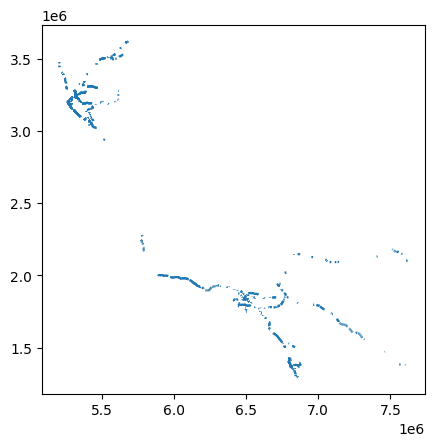

In [28]:
overlay_dissolve = overlay_len.dissolve(by=['route_id', 'route_name']).reset_index()

#now each row is a rail route segment

gdf_check(overlay_dissolve)


In [ ]:
#Checked overlay to get close look of overlay_dissolve map

#overlay_dissolve.explore()

In [33]:
#calulated percentage of overlayed rail route length by initial rail route length

overlay_p = overlay_dissolve.assign(percent = (overlay_dissolve.geom_len / overlay_dissolve.rail_len)*100)

overlay_p.head()

,route_id,route_name,geometry,hw_Route,County,District,RouteType,Direction,org_id,agency,route_type,shape_id,n_trips,base64_url,uri,rail_len,half_rail_len,geom_len,percent
0,36930,Sunset Limited,"MULTILINESTRING ((6496618.037 1844254.138, 649...",5,COL,3,Interstate,NB,recKsb5FnJy70up78,Amtrak,2,269,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,2.634938e+06,1.317469e+06,5317.310534,0.201800
1,398,COASTER,"MULTILINESTRING ((6798787.063 1426865.053, 679...",5,COL,3,Interstate,NB,recRBcrX4ZvTyvSnm,North County Transit District,2,3980014,15,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,4.387197e+05,2.193598e+05,158264.722030,36.074223
2,399,SPRINTER,"MULTILINESTRING ((6757649.538 1527224.791, 675...",5,COL,3,Interstate,NB,recRBcrX4ZvTyvSnm,North County Transit District,0,3990004,34,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,2.363734e+05,1.181867e+05,5284.295672,2.235571
3,507,Downtown - Folsom,"MULTILINESTRING ((5558074.390 3508899.695, 555...",5,COL,3,Interstate,NB,rec43oyrfhtPDdRHj,City of Rancho Cordova,0,46380,26,aHR0cHM6Ly9pcG9ydGFsLnNhY3J0LmNvbS9HVEZTL1NSVE...,https://iportal.sacrt.com/GTFS/SRTD/google_tra...,2.445130e+05,1.222565e+05,3990.836547,1.632157
4,51,Southwest Chief,"MULTILINESTRING ((6521677.857 1816236.426, 652...",5,COL,3,Interstate,NB,recKsb5FnJy70up78,Amtrak,2,118,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,3.479392e+06,1.739696e+06,12000.089516,0.344890


In [36]:
#function that checks every in overlay_p and returns 
def route_check(row):
    if 0 < row.percent < 50:
        return 'less than half of this routes length is near the SHN'
    elif row.percent > 50:
        return 'at least half of this routes length is near the SHN'
    else:
        return 'route is never .25miles from SHN'
    

In [38]:
#used apply method to create new column `route_check` that uses the function to fill in the rows based on the percent col.
overlay_p['route_check'] = overlay_p.apply(route_check, axis=1)

overlay_p.head()

,route_id,route_name,geometry,hw_Route,County,District,RouteType,Direction,org_id,agency,route_type,shape_id,n_trips,base64_url,uri,rail_len,half_rail_len,geom_len,percent,route_check
0,36930,Sunset Limited,"MULTILINESTRING ((6496618.037 1844254.138, 649...",5,COL,3,Interstate,NB,recKsb5FnJy70up78,Amtrak,2,269,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,2.634938e+06,1.317469e+06,5317.310534,0.201800,less than half of this routes length is near t...
1,398,COASTER,"MULTILINESTRING ((6798787.063 1426865.053, 679...",5,COL,3,Interstate,NB,recRBcrX4ZvTyvSnm,North County Transit District,2,3980014,15,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,4.387197e+05,2.193598e+05,158264.722030,36.074223,less than half of this routes length is near t...
2,399,SPRINTER,"MULTILINESTRING ((6757649.538 1527224.791, 675...",5,COL,3,Interstate,NB,recRBcrX4ZvTyvSnm,North County Transit District,0,3990004,34,aHR0cHM6Ly93d3cuZ29uY3RkLmNvbS9nb29nbGVfdHJhbn...,https://www.gonctd.com/google_transit.zip,2.363734e+05,1.181867e+05,5284.295672,2.235571,less than half of this routes length is near t...
3,507,Downtown - Folsom,"MULTILINESTRING ((5558074.390 3508899.695, 555...",5,COL,3,Interstate,NB,rec43oyrfhtPDdRHj,City of Rancho Cordova,0,46380,26,aHR0cHM6Ly9pcG9ydGFsLnNhY3J0LmNvbS9HVEZTL1NSVE...,https://iportal.sacrt.com/GTFS/SRTD/google_tra...,2.445130e+05,1.222565e+05,3990.836547,1.632157,less than half of this routes length is near t...
4,51,Southwest Chief,"MULTILINESTRING ((6521677.857 1816236.426, 652...",5,COL,3,Interstate,NB,recKsb5FnJy70up78,Amtrak,2,118,1,aHR0cHM6Ly9jb250ZW50LmFtdHJhay5jb20vY29udGVudC...,https://content.amtrak.com/content/gtfs/GTFS.zip,3.479392e+06,1.739696e+06,12000.089516,0.344890,less than half of this routes length is near t...


In [46]:
#checking values of new route_check col
overlay_p.route_check.value_counts()

less than half of this routes length is near the SHN    39
at least half of this routes length is near the SHN      3
Name: route_check, dtype: int64

In [53]:
#grouped by route check status, then districts #, the 

overlay_p.groupby(['route_check']).District.value_counts()

route_check                                           District
at least half of this routes length is near the SHN   1            1
                                                      3            1
                                                      7            1
less than half of this routes length is near the SHN  7           14
                                                      4           12
                                                      3           10
                                                      10           2
                                                      1            1
Name: District, dtype: int64

---
hall of shame (test stuff)

---

In [ ]:
#(list of) rail routes that are never within 0.25 miles of the SHN

#get CA rail routes - 'ca_rail2' (with buffered col)
#get CA highway map - `ca_highways2' (with buffered col)
#add new geom column to highway map that buffers to 1320ft
#use overlay to find rail routes that do not touch buffered geom col

#ca_rail2.head()


In [ ]:
#ca_highways2.head()ax = df1.plot(color='red');

#df2.plot(ax=ax, color='green', alpha=0.5);

In [ ]:
##Test to plot rail routes over highways.


#ax = ca_rail2.plot(color='red');

#ca_highways2.plot(ax=ax, color='green', alpha=0.5);

In [ ]:
#test overlay of `ca_rail2` and `ca_highways2`, Result: a map of rail routes that are NOT touching a highway

#testing different orders for overlays and how=

#highway_rail = gpd.overlay(ca_highways2, ca_rail2, how='symmetric_difference', keep_geom_type=True)
#rail_highway = gpd.overlay(ca_rail2, ca_highways2, how='symmetric_difference', keep_geom_type=True)

In [ ]:
#def test(x,y):
#    display(x.shape),
#    display(x.head()),
#    display(y.shape),
#    display(y.head()),
#    display(x.plot(color='red')),
#    display(y.plot(color='green'))
#    return

In [ ]:
#test(highway_rail, rail_highway)

In [ ]:
#from Amanda's ex. she:
#1. joined rail routes and rail stops (inner, intersects)
#2. overlayed highway(disolved) and rail routes join

In [ ]:
#what happens if you overlay points on polygon? which datasets are point and which are polygons?
#ca_rail_stops = points, ca_rail2 (bufferd rail routes) = polygon

#test = gpd.overlay(ca_rail_stops, ca_rail2, how='union', keep_geom_type=False)
#test.plot()

In [ ]:
#test of points on line
#ca_rail_stops on ca_rail

#dont think sjoin gives me what i imagine (example of sjoin is more closer to clipping)

#test of overlay
#how ='intersection`: from gdf1, 
#how ='difference': from gdf1 remove the part that is gf2

#does ca, ca_rail2, 'difference' show something different because both gdf have polygon geom type?

#what about if both gdf are lines?
#when its ca_highways,ca_rail2, difference: start to see gaps missing from highways

#join1 = gpd.overlay(ca_stops, ca_highways2, how = 'intersection', keep_geom_type = True)

#gdf_check(join1)

In [ ]:
#Test of sjoins
#sjoin ca_rail and ca_highways
#doesnt look like it works as we are plotting lines on lines

#join1 = gpd.sjoin(ca_rail2, ca_highways, how = 'inner', predicate = 'intersects')

#when sjoin is ca_rail2,ca_highways, inner, intersects, get 3000 rows and map looks like rail routes
#when sjoin is ca_rail2,ca_highways, left, intersects; similar results
#when sjoin is ca_rail2,ca_highways, inner, within; no data and no map
#when sjoin is ca_rail2,ca_highways, inner, contains; 68 rows, looks to be northern california
#when sjoin is ca_rail2,ca_highways, inner, touches; no data no map
#when sjoin is ca_rail2,ca_highways, inner, overlaps; no data no map

#gdf_check(join1)

In [ ]:
#test of same sjoin, but swapping order. not working, says geometry col not set and cant plot

# when ca_highway, ca_ril2, inner, intersects: 

#join2 = gpd.sjoin(ca_highways, ca_rail2.set_geometry('geom_buff'), how = 'inner', predicate = 'intersects')
#join2.head()


In [ ]:
#ca_rail is rail routes in CA buffered to 1320ft(.25miles)
#gdf_check(ca_rail)

In [ ]:
#ca_highways.plot()

In [ ]:
# add new col for length and half-legth of rail route from ca_rail
# may need this later to update buffer
#ca_rail = ca_rail.assign(length = ca_rail.geometry.length)
#ca_rail.head()

In [ ]:
#Test of overlay districts and ca_rail_buffer 

#overlay = gpd.overlay(
#    districts2229,
#    ca_rail_buffer.set_geometry('g_buffer'),
#    how = 'difference',
#    keep_geom_type=True
#)


In [ ]:
#districts2229

In [ ]:
#ca_rail_buffer.head(2)

In [ ]:
#got something when i overlay districts and rail routes!

#inspect what happens to the geometry column after overlaying. are there any duplicate rows? if so, why.
#are the routes the same after the overlay?
#remember to use length, and % of something. 
# 
#display(overlay)
#display(overlay.geometry.name)
#overlay.plot()

In [ ]:
#import matplotlib.pyplot as plt



In [ ]:
#try dissolving highways2999.
#overlay changes geometry values.
#try overlay to get length of rail route that interects
#try to find difference of overlayed geomety from SHN

#highways2229

In [ ]:
#found this via youtube tutorial.
#maps the highways and rail routes over distrcts

#fig, ax = plt.subplots(figsize = (10,8))
#highways2229.plot(ax = ax, edgecolor = 'black')
#ca_rail_buffer.plot(ax= ax, edgecolor = 'white')
#districts2229.plot(ax = ax)